In [ ]:
from shapely.geometry import MultiPoint, Polygon, LineString
import shapely.geometry as g
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
import matplotlib.pyplot as plt
from descartes.patch import PolygonPatch
import numpy as np
from math import sqrt
from shapely import affinity
import os
import math
from pprint import pprint
import cvxpy


GM = (sqrt(5)-1.0)/2.0
W = 8.0
H = W*GM
SIZE = (W, H)

BLUE = '#6699cc'
GRAY = '#999999'
DARKGRAY = '#333333'
YELLOW = '#ffcc33'
GREEN = '#339933'
RED = '#ff3333'
BLACK = '#000000'

COLOR_ISVALID = {
    True: BLUE,
    False: RED,
}

def rect2poly(ll, ur):
    """
    Convert rectangle defined by lower left/upper right
    to a closed polygon representation.
    """
    x0, y0 = ll
    x1, y1 = ur

    return [
        [x0, y0],
        [x0, y1],
        [x1, y1],
        [x1, y0],
        [x0, y0]
    ]


def get_intersection(coords):
    """Given an input list of coordinates, find the intersection
    section of corner coordinates. Returns geojson of the
    interesection polygon.
    """
    ipoly = None
    for coord in coords:
        if ipoly is None:
            ipoly = Polygon(coord)
        else:
            tmp = Polygon(coord)
            ipoly = ipoly.intersection(tmp)

    # close the polygon loop by adding the first coordinate again
    first_x = ipoly.exterior.coords.xy[0][0]
    first_y = ipoly.exterior.coords.xy[1][0]
    ipoly.exterior.coords.xy[0].append(first_x)
    ipoly.exterior.coords.xy[1].append(first_y)

    inter_coords = zip(
        ipoly.exterior.coords.xy[0], ipoly.exterior.coords.xy[1])

    inter_gj = {"geometry":
                {"coordinates": [inter_coords],
                 "type": "Polygon"},
                "properties": {}, "type": "Feature"}

    return inter_gj, inter_coords


def two_pts_to_line(pt1, pt2):
    """
    Create a line from two points in form of

    a1(x) + a2(y) = b
    """
    pt1 = [float(p) for p in pt1]
    pt2 = [float(p) for p in pt2]
    try:
        slp = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0])
    except ZeroDivisionError:
        slp = 1e5 * (pt2[1] - pt1[1])
    a1 = -slp
    a2 = 1.
    b = -slp * pt1[0] + pt1[1]

    return a1, a2, b


def pts_to_leq(coords):
    """
    Converts a set of points to form Ax = b, but since
    x is of length 2 this is like A1(x1) + A2(x2) = B.
    returns A1, A2, B
    """

    A1 = []
    A2 = []
    B = []
    for i in range(len(coords) - 1):
        pt1 = coords[i]
        pt2 = coords[i + 1]
        a1, a2, b = two_pts_to_line(pt1, pt2)
        A1.append(a1)
        A2.append(a2)
        B.append(b)
    return A1, A2, B


def get_maximal_rectangle(coordinates):
    """
    Find the largest, inscribed, axis-aligned rectangle.

    :param coordinates:
        A list of of [x, y] pairs describing a closed, convex polygon.
    """

    coordinates = np.array(coordinates)
    x_range = np.max(coordinates, axis=0)[0]-np.min(coordinates, axis=0)[0]
    y_range = np.max(coordinates, axis=0)[1]-np.min(coordinates, axis=0)[1]

    scale = np.array([x_range, y_range])
    sc_coordinates = coordinates/scale

    poly = Polygon(sc_coordinates)
    inside_pt = (poly.representative_point().x,
                 poly.representative_point().y)

    A1, A2, B = pts_to_leq(sc_coordinates)

    bl = cvxpy.Variable(2)
    tr = cvxpy.Variable(2)
    br = cvxpy.Variable(2)
    tl = cvxpy.Variable(2)
    obj = cvxpy.Maximize(cvxpy.log(tr[0] - bl[0]) + cvxpy.log(tr[1] - bl[1]))
    constraints = [bl[0] == tl[0],
                   br[0] == tr[0],
                   tl[1] == tr[1],
                   bl[1] == br[1],
                   ]

    for i in range(len(B)):
        if inside_pt[0] * A1[i] + inside_pt[1] * A2[i] <= B[i]:
            constraints.append(bl[0] * A1[i] + bl[1] * A2[i] <= B[i])
            constraints.append(tr[0] * A1[i] + tr[1] * A2[i] <= B[i])
            constraints.append(br[0] * A1[i] + br[1] * A2[i] <= B[i])
            constraints.append(tl[0] * A1[i] + tl[1] * A2[i] <= B[i])

        else:
            constraints.append(bl[0] * A1[i] + bl[1] * A2[i] >= B[i])
            constraints.append(tr[0] * A1[i] + tr[1] * A2[i] >= B[i])
            constraints.append(br[0] * A1[i] + br[1] * A2[i] >= B[i])
            constraints.append(tl[0] * A1[i] + tl[1] * A2[i] >= B[i])

    prob = cvxpy.Problem(obj, constraints)
    prob.solve(verbose=False, max_iters=1000, reltol=1e-9)
    bottom_left = np.array(bl.value).T * scale
    top_right = np.array(tr.value).T * scale

    return ((bottom_left[0],top_right[1]),tuple(bottom_left), (top_right[0],bottom_left[1]),tuple(top_right),(bottom_left[0],top_right[1]))


fig = plt.figure(1, figsize=(10,10), dpi=72)
fig.set_frameon(True)
coords = np.array([[135.182647705078, 34.688277852776], [135.182617194, 34.688266472], [135.182610694, 34.688271917], [135.182609444, 34.688277806], [135.182608306, 34.688283306], [135.182297833, 34.688253556], [135.182064722, 34.688168639], [135.182022278, 34.688233111], [135.181988917, 34.688313389], [135.181993528, 34.688315083], [135.181981361, 34.68833175], [135.181981528, 34.688336083], [135.181987222, 34.688339194], [135.182047, 34.68835725], [135.182052, 34.688355333], [135.182054111, 34.688348472], [135.182180333, 34.688397333], [135.182192833, 34.688392306], [135.182293389, 34.688428389], [135.182258194, 34.688487583], [135.182215778, 34.688553694], [135.182224595609, 34.6885571561537],
[135.182224595609, 34.6885571561537], [135.182245778, 34.688565278], [135.182271306, 34.688575111], [135.182261083, 34.688587444], [135.182255194, 34.68859], [135.182250778, 34.688595722], [135.182253583, 34.688602556], [135.182258083, 34.688604583], [135.182570583, 34.688746389], [135.182643222, 34.688666722], [135.182639361, 34.688653694], [135.182587056, 34.688628722], [135.182580639, 34.68863075], [135.182578611, 34.688634917], [135.182413861, 34.688565278],[135.182414389, 34.688564111], [135.182417170911, 34.6885571561537],[135.182417170911, 34.6885571561537], [135.182418556, 34.688555056], [135.182416972, 34.688550222], [135.182382667, 34.6885345], [135.182432417, 34.68843625], [135.18249025, 34.688457028], [135.182496778, 34.688456361], [135.182499611, 34.688454972], [135.182521472, 34.688414722], [135.182562083, 34.688428583], [135.182568833, 34.688426833], [135.182575, 34.688421917], [135.182579472, 34.688410167], [135.182581806, 34.688403028], [135.182616083, 34.688414056], [135.182627083, 34.688413694], [135.182638722, 34.688408222], [135.182642472, 34.688401778], [135.182647705078, 34.6884023788111],[135.182651639, 34.688403083], [135.182702917, 34.688303833], [135.182701111, 34.688298056], [135.182696833, 34.688295583], [135.182687528, 34.688292667], [135.182647705078, 34.688277852776]])

ls = Polygon(coords)

rect = ls.minimum_rotated_rectangle
convex_hull = ls.convex_hull

x1,y1 = rect.centroid.xy
x2,y2 = ls.centroid.xy
x1,y1 = x1[0],y1[0]
x2,y2 = x2[0],y2[0]

translated_rect = affinity.translate(rect,x2-x1,y2-y1)

#3
# 各頂点から中心に線を引きconvex hullとの交点を算出する。さらに[交点からcentroidまでの距離]/[頂点からcentroidまでの距離]を算出する。

ax = fig.add_subplot(111)
#ax.set_title('3. calculate (distance from intersection point to centroid) / \n(distance from vertex to centroid)\n,and then select minimum one (min_rate)')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axis('equal')
#ax.plot(*ls.xy, color=DARKGRAY, linewidth=1, alpha=0.5, zorder=10)
patch = PolygonPatch(ls, facecolor=BLUE, edgecolor=BLUE, alpha=0.25, zorder=2)
ax.add_patch(patch)

# patch = PolygonPatch(ls.convex_hull, facecolor=YELLOW, edgecolor=YELLOW, alpha=0.25, zorder=2)
# ax.add_patch(patch)
min_rate = None

for pt in translated_rect.exterior.coords :
    lst = LineString((pt,(x2,y2)))
    intersects = ls.convex_hull.intersection(lst)
    if(intersects.type == 'MultiLineString') :
        for i in intersects :
            #ax.plot(*i.xy,color=BLUE,linewidth=1,linestyle="dashed")
            if(min_rate == None) : 
                min_rate = i.length / lst.length
            else :
                min_rate = min(min_rate,i.length / lst.length)
    else :    
        #ax.plot(*intersects.xy,color=BLUE,linewidth=1,linestyle="dashed")
        if(min_rate == None) : 
            min_rate = intersects.length / lst.length
        else :
            min_rate = min(min_rate,intersects.length / lst.length)

patch = PolygonPatch(translated_rect, facecolor=RED, edgecolor=RED, alpha=0.5, zorder=3)
ax.add_patch(patch)

shrinked_rect = affinity.scale(translated_rect,min_rate,min_rate,1.0,(x2,y2))

patch = PolygonPatch(shrinked_rect, facecolor=RED, edgecolor=RED, alpha=0.5, zorder=3)
ax.add_patch(patch)

# rect = Polygon(get_maximal_rectangle(coords))


# patch = PolygonPatch(rect, facecolor=BLUE, edgecolor=BLUE, alpha=0.5, zorder=3)
# ax.add_patch(patch)

# patch = PolygonPatch(ls.convex_hull, fill=False,facecolor=None, edgecolor=YELLOW, alpha=0.5, zorder=3)
# ax.add_patch(patch)

# patch = PolygonPatch(ls.envelope, fill=False,facecolor=None, edgecolor='#000000', alpha=0.2, zorder=3)
# ax.add_patch(patch)

xs,ys,xe,ye = ls.convex_hull.bounds

coords_p = np.empty(0)

def plot(ax,o) :
    if(o.type == 'LineString') :
        ax.scatter(*o.xy,marker='.')
    elif(o.type == 'MultiLineString') :
        for l in o :
            ax.scatter(*l.xy,marker='.')
    elif(o.type == 'Point') :
        ax.scatter(*o.xy,marker='.')
    elif(o.type == 'GeometryCollection') :
        for o1 in o :
            plot(ax,o1)

def get_points(o) :
    global coords_p
    if(o.type == 'LineString') :
        coords_p = np.append(coords_p,o.coords)
    elif(o.type == 'MultiLineString') :
        for l in o :
            get_points(l)
    elif(o.type == 'Point') :
        coords_p = np.append(coords_p,o.coords)
    elif(o.type == 'GeometryCollection') :
        for o1 in o :
            get_points(o1)


for x,y in ls.exterior.coords :
    coords_p = np.append(coords_p,[x,y])
    lx = g.LineString([[x,ys],[x,ye]])
    ly = g.LineString([[xs,y],[xe,y]])
    intx = lx.intersection(ls)
    inty = ly.intersection(ls)
    #plot(ax,intx)
    #plot(ax,inty)
    get_points(intx)
    get_points(inty)
    #print(intx)
    #ax.plot((x,x),(ys,ye),color='#0000ff',linewidth=0.5,alpha=0.2)
    #ax.plot((xs,xe),(y,y),color='#0000ff',linewidth=0.5,alpha=0.2)

coords_p = coords_p.reshape(-1,2)
for p in coords_p :
    pt = g.Point(p[0],p[1])
    ax.plot(*pt.xy,marker='.')

#print(coords_x,coords_y)
#ax.plot(ls.centroid.x,ls.centroid.y,marker='.')
plt.show()

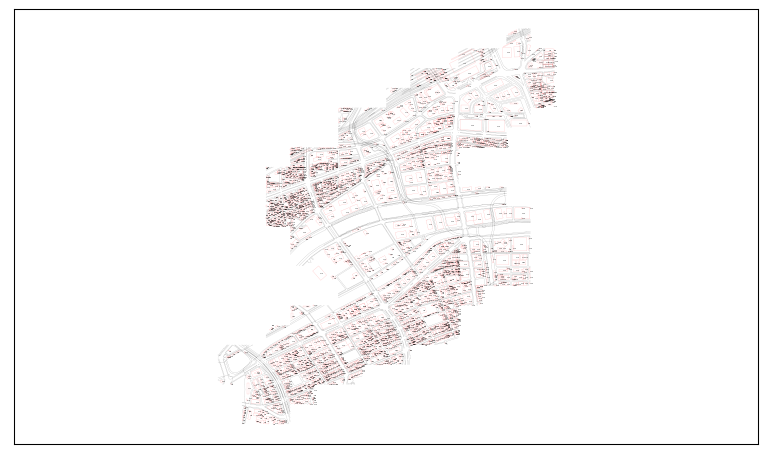

In [6]:
import json
import re
import  shapely.geometry as g
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
import matplotlib.pyplot as plt
from descartes.patch import PolygonPatch
import numpy as np
import math
from get_height import get_jaxa_dsm_height,get_tile_num,get_jaxa_dsm_height_rect


fig = plt.figure(1, figsize=(10,6), dpi=96)
fig.set_frameon(True)
ax = fig.add_subplot(111)
#ax.set_title('3. calculate (distance from intersection point to centroid) / \n(distance from vertex to centroid)\n,and then select minimum one (min_rate)')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axis('equal')
re_bld  = re.compile('Bld')

work_dir = '../../temp/'

# map = None
# with open(f'{work_dir}merged_org.json','r') as f :
#   root_map_str = f.read()
#   map = json.loads(root_map_str) 

# for map in map['maps'] :
#   lines = [f['geometry']['coordinates'] for f in map['features'] if len(np.shape(f['geometry']['coordinates'])) > 1 ]
#   for ls in lines :
#     lso = g.LineString(ls)
#     ax.plot(*lso.xy, color="#000000", linewidth=0.2, alpha=0.25, zorder=1,linestyle="dashed")

# map = None
# with open(f'{work_dir}merged_ch.json','r') as f :
#   root_map_str = f.read()
#   map = json.loads(root_map_str) 

# for map in map['maps'] :
#   lines = [f['geometry']['coordinates'] for f in map['features'] if re_bld.match(f['properties']['class']) and len(np.shape(f['geometry']['coordinates'])) > 1 ]
#   for ls in lines :
#     lso = g.LineString(ls)
    # ax.plot(*lso.xy, color="#00ff00", linewidth=0.2, alpha=0.25, zorder=1)

map = None
with open(f'{work_dir}merged_simple.json','r') as f :
  root_map_str = f.read()
  map = json.loads(root_map_str) 

grid = []
gxmin = None
gxmax = None
gymin = None
gymax = None

for map in map['maps'] :
  attr = map['attributes']
  gxmin = min(gxmin,attr['xmin']) if gxmin != None else attr['xmin']
  gymin = min(gymin,attr['ymin']) if gymin != None else attr['ymin']
  gxmax = max(gxmax,attr['xmax']) if gxmax != None else attr['xmax']
  gymax = max(gymax,attr['ymax']) if gymax != None else attr['ymax']
  
  # for dem in attr['dems_flat'] :
  #   ax.text(dem[0],dem[1],dem[2],size=1,color='#00c000')
  #lines = [f for f in map['features'] if re_bld.match(f['properties']['class']) and len(np.shape(f['geometry']['coordinates'])) > 1 ]
  lines = [f for f in map['features'] if len(np.shape(f['geometry']['coordinates'])) > 1 ]
  for f in lines :
    lso = g.LineString(f['geometry']['coordinates'])
    color = '#000000'
    if(re_bld.match(f['properties']['class'])) :
      color = '#ff0000'
    ax.plot(*lso.xy, color=color, linewidth=0.1, alpha=0.5, zorder=1)
    #ax.text(lso.centroid.x,lso.centroid.y,f'fid:{f["properties"]["fid"]}:{f["properties"]["type"]}',size=0.1)
    if('height' in f["properties"]) :
      ax.text(lso.centroid.x,lso.centroid.y,f'{f["properties"]["height"]:3.1f}m',size=1)

# map = None
# with open(f'{work_dir}merged_simple4.json','r') as f :
#   root_map_str = f.read()
#   map = json.loads(root_map_str) 

# for map in map['maps'] :
#   #lines = [f for f in map['features'] if re_bld.match(f['properties']['class']) and (f["properties"]["tg_cv_rate"] >= 0.82 and f["properties"]["tg_min_rate"] < 0.3) and len(np.shape(f['geometry']['coordinates'])) > 1 ]
#   lines = [f for f in map['features'] if re_bld.match(f['properties']['class']) and len(np.shape(f['geometry']['coordinates'])) > 1 ]
#   for f in lines :
#     p = g.Polygon(f['geometry']['coordinates'])
#     patch = PolygonPatch(p, facecolor=None, edgecolor='#0000ff',alpha=0.5, linewidth=0.1,zorder=1,fill=False)
#     ax.add_patch(patch)
#     #ax.plot(*lso.xy, color="#0000ff", linewidth=0.1, alpha=0.5, zorder=1,linestyle="dashed")
#     #ax.text(p.centroid.x,p.centroid.y,f'c:{f["properties"]["tg_cv_rate"]:.3f}\nm:{f["properties"]["tg_min_rate"]:.3f}',size=0.1)

# map = None
# with open(f'{work_dir}test.json','r') as f :
#   root_map_str = f.read()
#   map = json.loads(root_map_str)
# #print(map['features'][0]['geometry']['coordinates'])
# lso = g.LineString(map['features'][0]['geometry']['coordinates'])
# ax.plot(*lso.xy,color='#0000ff',linewidth=2,alpha=1,zorder=1,linestyle="dashed")

gxmin = math.floor(gxmin * 3600) / 3600
gxmax = math.ceil(gxmax * 3600) / 3600
gymin = math.floor(gymin * 3600) / 3600
gymax = math.ceil(gymax * 3600) / 3600
gxrange = np.arange(gxmin,gxmax,1/3600)
gyrange = np.arange(gymin,gymax,1/3600)
#print(gxmin,gxmax,gymin,gymax)

# for x in gxrange :
#   ax.plot([x,x],[gymin,gymax],color='#00ff00',linewidth=0.2,alpha=0.5,linestyle="dashed")

# for y in gyrange :
#   ax.plot([gxmin,gxmax],[y,y],color='#00ff00',linewidth=0.2,alpha=0.5,linestyle="dashed")

# for x in gxrange :
#   for y in gyrange :
#     ax.text(x - 1/7200,y - 1/7200,f'{get_jaxa_dsm_height(x,y)[0]}m',color='#0000ff',size=1)
plt.show()
#plt.savefig("line.svg",format="svg",dpi=96)
    

In [ ]:
import gdal
import requests
import numpy as np
import math
import os
import json
import colorsys
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
import matplotlib.pyplot as plt
from descartes.patch import PolygonPatch

garea = np.array([140.7263888888889, 140.73777777777778, 41.76916666666666, 41.7775])
gareai = garea.astype(np.int)
gareap =  ((garea - gareai) * 3600).astype(np.int)

gxmin,gxmax,gymax,gymin = gareap
gymin  = 3600 - gymin
gymax = 3600 - gymax

dsm_path = f'../../temp/basedata/ALPSMLC30_N{gareai[2]:03}E{gareai[0]:03}_DSM.tif'
print(dsm_path)
dsm = gdal.Open(dsm_path,gdal.GA_ReadOnly)
dsm_band = dsm.GetRasterBand(1).ReadAsArray()
dsm_band = np.log2(dsm_band.astype(np.float))
fig = plt.figure(1, figsize=(10,10), dpi=400)
fig.set_frameon(False)
ax = fig.add_subplot(111)
ax.set_facecolor('#000080')
ax.set_alpha(0.5)
ax.imshow(dsm_band,zorder=1,interpolation='nearest',aspect="equal",cmap="gist_earth")
ax.axis('equal')
#ax.plot([gxmin,gxmin,gxmax,gxmax,gxmin],[gymin,gymax,gymax,gymin,gymin],color='#ff0000',linewidth=0.2,alpha=1,zorder=10)

plt.show()

[1733 1913 2346 2489]


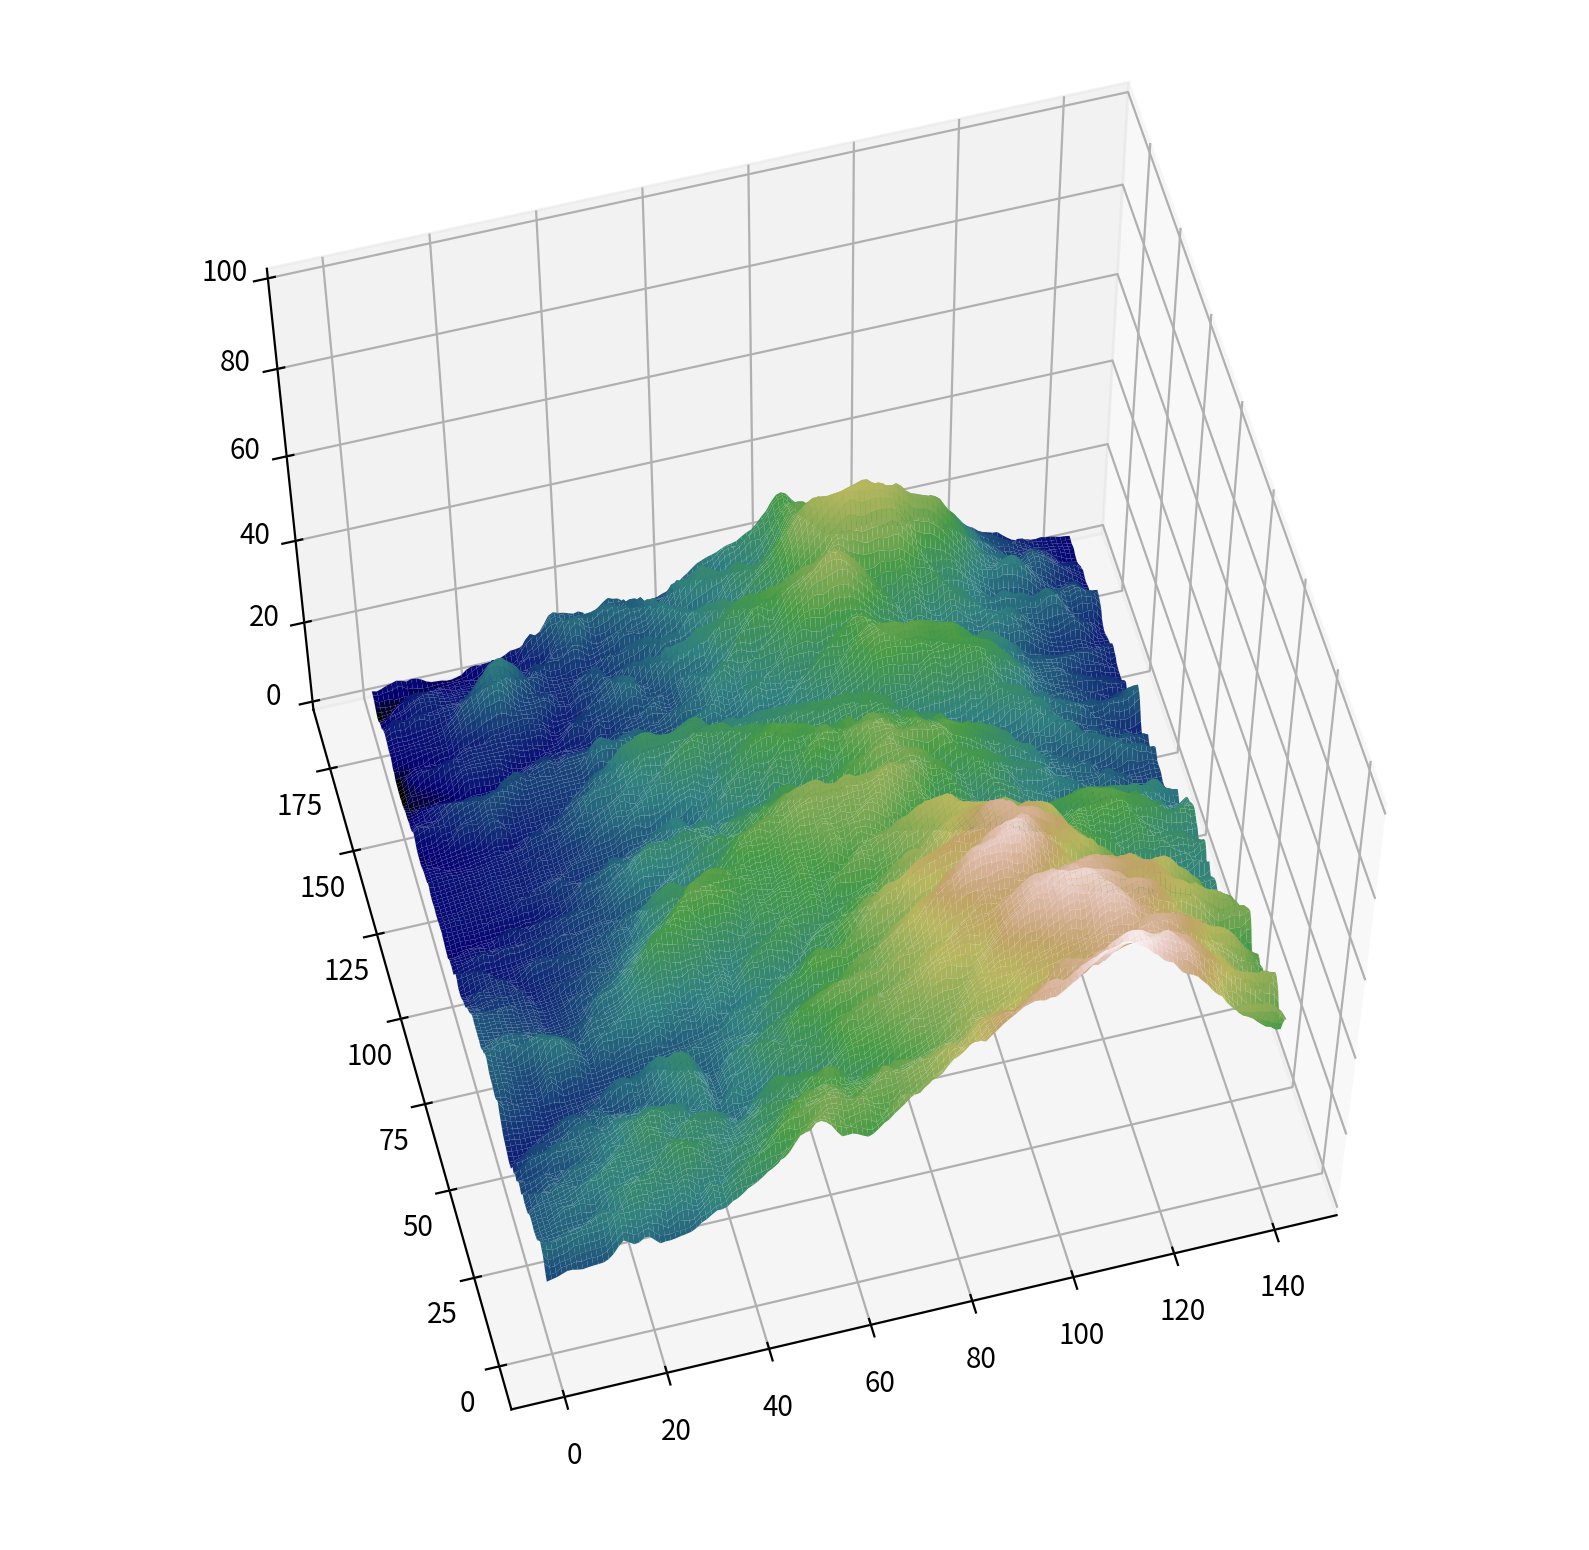

In [92]:
import gdal
import requests
import numpy as np
import math
import os
import json
import colorsys
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
import matplotlib.pyplot as plt
from descartes.patch import PolygonPatch

garea = np.array([135.4814174852604,135.53139214606222, 34.651775268212205,34.69163854363347])
gareai = garea.astype(np.int)
gareap = ((garea - gareai) * 3600).astype(np.int)
print(gareap)

dsm_path = f'../../temp/basedata/ALPSMLC30_N{gareai[2]:03}E{gareai[0]:03}_DSM.tif'
dsm = gdal.Open(dsm_path,gdal.GA_ReadOnly)
dsm_band = dsm.GetRasterBand(1).ReadAsArray()
#dsm_band = dsm_band[3600-gareap[1]:3600-gareap[0],gareap[2]:gareap[3]]
dsm_band = dsm_band / 10
shape = np.shape(dsm_band)
fig = plt.figure(1, figsize=(10,10), dpi=200)
x = np.arange(0,shape[1],1)
y = np.arange(shape[0],0,-1)
x,y = np.meshgrid(x, y)
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(x,y,dsm_band,cmap="gist_earth",rstride=1, cstride=1)
ax.set_zlim(0,100)
ax.view_init(60,-105)
# #ax.imshow(x,y,dsm_band,zorder=1,interpolation='nearest',aspect="equal",cmap="gist_earth")
# #ax.axis('equal')

plt.show()